# ComputeWannierOrbitalStats.py is now more complete.
But this notebook is good for a quick look at what we're doing.

In [4]:
#And for IPython Notebooks:
# Created 2018, Zack Gainsforth
%pylab inline
import sys, os
import QuickPlot
import matplotlib.pylab as pylab
from mpl_toolkits.mplot3d import Axes3D
pylab.rcParams['figure.figsize'] = 8, 6  # that's default image size for this interactive session
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from ipywidgets.widgets import interactive, fixed, interact
%config InlineBackend.figure_format = 'retina'

from ReadXSFVolume import ReadXSFVolume

Populating the interactive namespace from numpy and matplotlib


/Users/Zack/anaconda/envs/conda36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['interactive']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# Normalize wavefunction.
def NormPsi(Psi):
    UnNorm = np.sum(np.real(np.conj(Psi)*Psi))
    Psi /= np.sqrt(UnNorm)
    return Psi

# Psi squared
def Integrate(Psi):
    return(np.sum(np.real(np.conj(Psi)*Psi)))

# Expectation value of the electron radius.
def IntegrateMomentR(Psi):
    return(np.sum(np.real(np.conj(Psi)*meshR*Psi)))

def ShowWaveFuncStats(Psi):
    print(f'<Psi|Psi> = {Integrate(Psi)}')
    print(f'<Psi|R|Psi> = {IntegrateMomentR(Psi)} Bohr')

    # Laplacian on Psi.
    p = np.gradient(Psi,dx)
    p00 = np.gradient(p[0],dx)
    p11 = np.gradient(p[1],dx)
    p22 = np.gradient(p[2],dx)
    p2 = p00[0] + p11[1] + p22[2]
    # Kinetic energy
    E = np.conj(Psi)*(-p2)/2
    # Potential energy
    U = np.conj(Psi)*(-Z)/meshR*Psi
    TotalE = E+U
    
    # Output the energies.  
    # (Output the imaginary parts too just as a sanity check.  They should be 0.)
    print(f'Ereal = {np.sum(np.real(E)):0.4g} Hartrees')
    print(f'Eimag = {np.sum(np.imag(E)):0.4g} Hartrees')
    print(f'Ureal = {np.sum(np.real(U)):0.4g} Hartrees')
    print(f'Uimag = {np.sum(np.imag(U)):0.4g} Hartrees')
    print(f'Total Energy = {np.sum(np.real(TotalE)):0.4g} Hartrees')

    # Draw the energy 
    Plot3Planes(np.real(TotalE), '<Psi|H|Psi>')
    
    # Compute the orbital angular momentum.
    # Make p vector, p = -i*grad(psi)
    p = np.gradient(Psi,dx)
    px = -1j*p[0].astype('complex128')
    py = -1j*p[1].astype('complex128')
    pz = -1j*p[2].astype('complex128')

    # L = r x p
    Lx = meshY*pz - meshZ*py
    Ly = meshX*pz - meshZ*px
    Lz = meshX*py - meshY*px

    # L squared
    L2 = np.conj(Lx)*Lx + np.conj(Ly)*Ly + np.conj(Lz)*Lz

    print(f'<L|L> = {np.sum(np.real(L2)):0.4g} hbar (L**2)')

    # Projection of L onto z axis for mz
    zdotL = np.sqrt(np.sum(np.real(Lz)**2)) - np.sqrt(np.sum(np.imag(Lz)**2))
    print(f'<z|L> = {zdotL:0.4g} hbar (mz)')

    # We can draw the angular momentum too.
    # Typically the values are real, or complex, not both.  So we just mix them for drawing.
    Plot3Planes(np.real(Lz) + np.imag(Lz), 'Lz - real')
    #Plot3Planes(np.imag(Lz), 'Lz - imag')

In [46]:
X,Y,Z,V = ReadXSFVolume('NiO_00001.xsf', verbose=False)

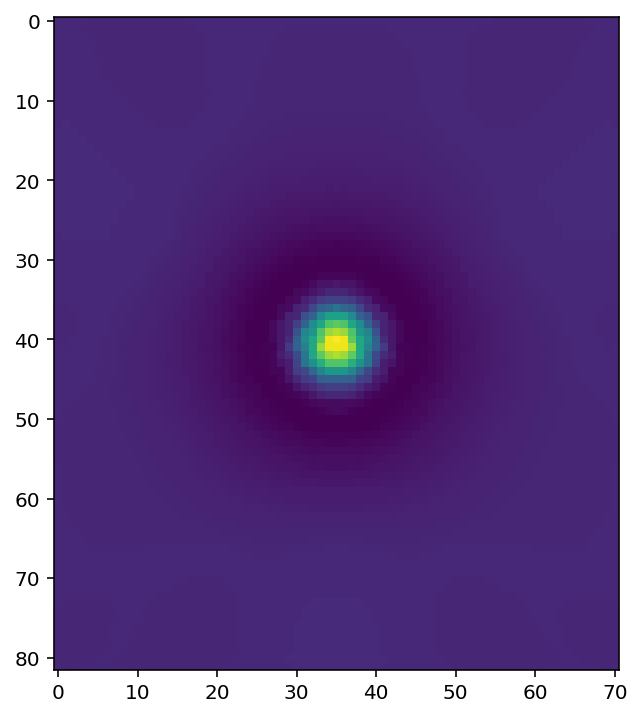

In [57]:
meshX = X.copy()
meshY = Y.copy()
meshZ = Z.copy()
Psi = V.copy()
imshow(Psi[Psi.shape[0]//2,:,:])
imshow(Psi[:,Psi.shape[1]//2,:])
imshow(Psi[:,:,Psi.shape[2]//2])


# The meshes are in A but need to be in bohr.
meshX /= 0.529177249
meshY /= 0.529177249
meshZ /= 0.529177249

In [58]:
Psi = NormPsi(Psi)

/Users/Zack/anaconda/envs/conda36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


<Psi|Psi> = 1.0
<Psi|R|Psi> = 1.552815627746895 Bohr
Ereal = 2.672 Hartrees
Eimag = 0 Hartrees
Ureal = 0.001741 Hartrees
Uimag = 0 Hartrees
Total Energy = 2.673 Hartrees
(82, 71, 174)
<L|L> = 7.321 hbar (L**2)
<z|L> = -1.252 hbar (mz)
(82, 71, 174)


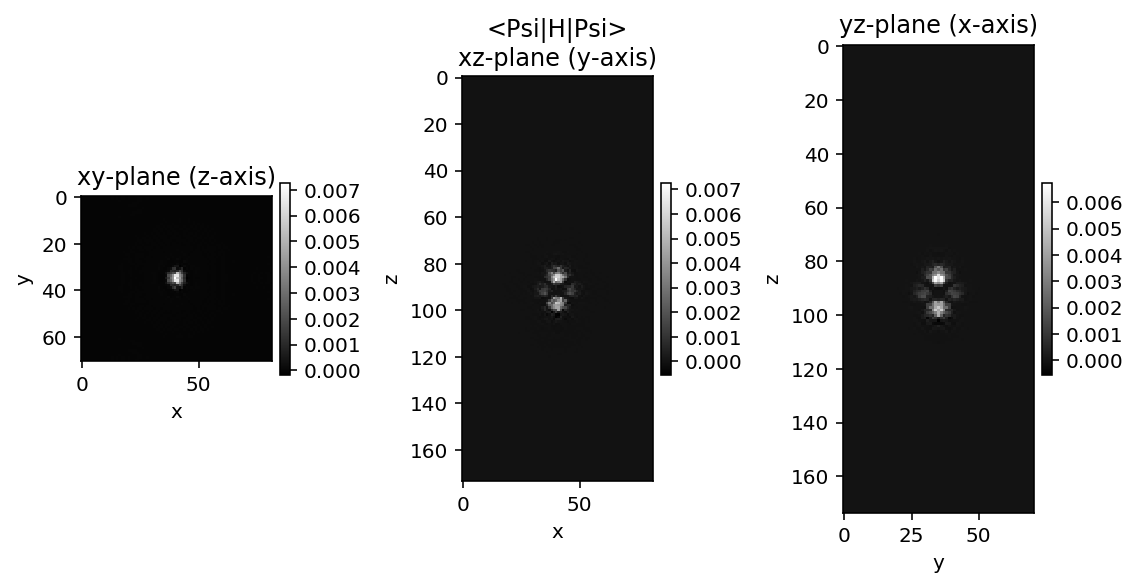

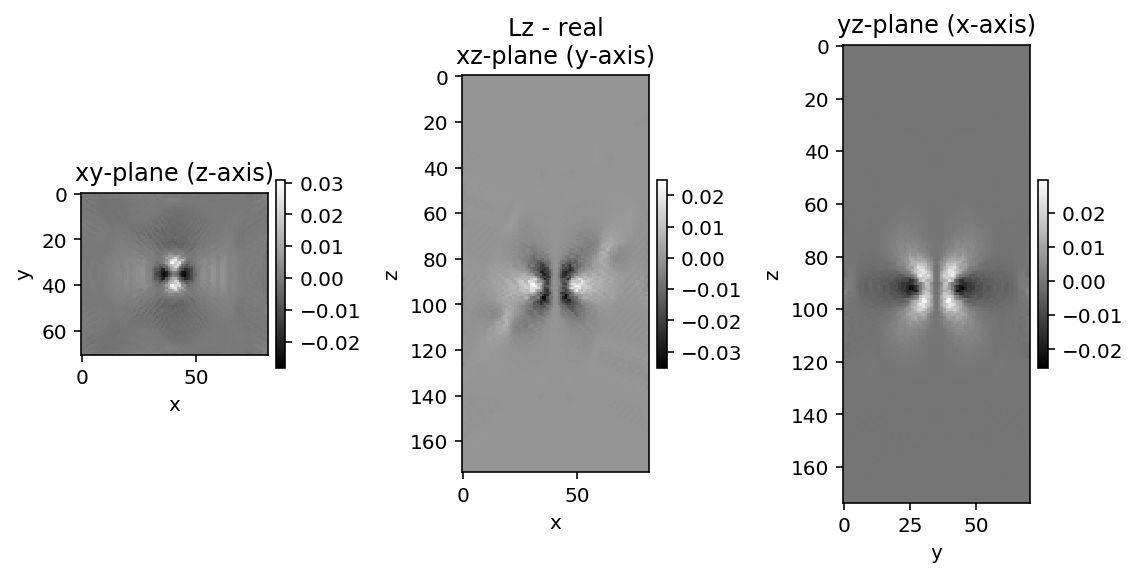

In [60]:
meshR = np.sqrt(meshX**2 + meshY**2 + meshZ**2)
meshT = -np.arccos(meshZ/meshR) + np.pi
meshP = np.arctan(meshY/meshX)
meshP[meshX<0] += np.pi
meshP += np.pi/2
dx = meshX[0,1,0] - meshX[0,0,0]

IntegrateMomentR(Psi)
ShowWaveFuncStats(Psi)

In [53]:
def Plot3Planes(mesh, title=''):
    print(mesh.shape)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3)
    im = ax1.imshow(mesh[:,:,mesh.shape[2]//2].T, cmap='gray')
    fig.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title('xy-plane (z-axis)')
    
    im = ax2.imshow(mesh[:,mesh.shape[1]//2,:].T, cmap='gray')
    fig.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
    ax2.set_xlabel('x')
    ax2.set_ylabel('z')
    ax2.set_title(title + '\nxz-plane (y-axis)')
    
    im = ax3.imshow(mesh[mesh.shape[0]//2,:,:].T, cmap='gray')
    fig.colorbar(im, ax=ax3, fraction=0.046, pad=0.04)
    ax3.set_xlabel('y')
    ax3.set_ylabel('z')
    ax3.set_title('yz-plane (x-axis)')
    plt.tight_layout()
    
def PlotOrbital(mesh, OrbitalName=''):
    Plot3Planes(np.real(np.conj(Psi)*Psi), OrbitalName + '<Psi|Psi>')
    Plot3Planes(np.real(Psi), OrbitalName + '<1|Psi>')
    Plot3Planes(np.imag(Psi), OrbitalName + '<i|Psi>')
    
    from tifffile import imsave
    imsave(OrbitalName+'.tif', np.real(np.conj(Psi)*Psi).astype('float32'))

